We have seen conjugate priors that are nice and have some explanation for us to understand to boot. But the algebra can be tediousm and while we can build all these examples, we run the danger of bending the model to algrebra. The best thing to do is to adapt our prior to the situation, and make sure the priors do not strongly inﬂuence the posterior distribution.

In Bayesian modeling, we always need to construct prior distribution of parameters that we want to infer about. There are a number of approaches to do this:

1. Flat priors and transformation
2. Uninformative priors
    - jeffrey priors
    - jeffrey's priors for the normal-normal model
    - KL-maximization priors
3. Weakly informative or regularizing prior
    - normal-normal example
    - weakly regularizing priors on $\mu$, $\sigma$
4. Other choices
    - maximum entropy priors (gaussian?)
    - emprirical bayes priors
5. Priors lose their powers as N increases (more data).

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from scipy.stats import beta
import seaborn as sn
from scipy.stats import norm

plt.rcParams['figure.figsize'] = (12,6)

# Flat priors and transformation

What we want are uninformative priors.
Let us first consider priors on location. Why not assign flat priors? Are not those the most un-informative? Since we do not know where the actual value lies in the parameter space, we might as well consider all values with equal probability. This prior however is not transformation invariant. What does this mean? Suppose we have a random variable X from $Bernoulli(\theta)$. We define the prior $p(\theta)=1$.

We define a prior $p(\theta) = 1$ on the range $[0,1]$

(0, 2)

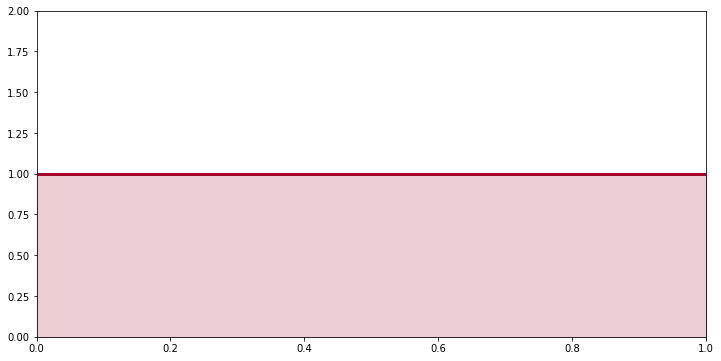

In [3]:
x = np.linspace( 0.000 ,1, 150 )
y = np.linspace( 1.0, 1.0, 150 )
lines = plt.plot( x, y, color="#A60628", lw = 3 )
plt.fill_between( x, 0, y, alpha = 0.2, color = lines[0].get_color() )
plt.autoscale(tight=True)
plt.ylim( 0, 2)

We now peform a logit transform $log(\frac{\theta}{1-\theta})$, which stretch $\theta$ across the real line.

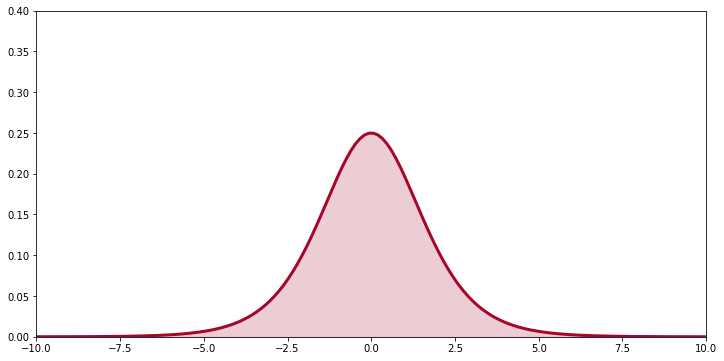

In [4]:
psi = np.linspace( -10 ,10, 150 )
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot( psi, y, color="#A60628", lw = 3 )
plt.fill_between( psi, 0, y, alpha = 0.2, color = lines[0].get_color() )
plt.autoscale(tight=True)
plt.ylim( 0, .4);

This is not a flat prior, which is to say our original $p(\theta) = 1$ do carry information after all.

Another way to think about this is the beta-binomial model in which you use a uniform, ie a Beta(1,1) prior. This adds one “success” and one “failure”, which in the limit of low data can have quite a regularizing effect.


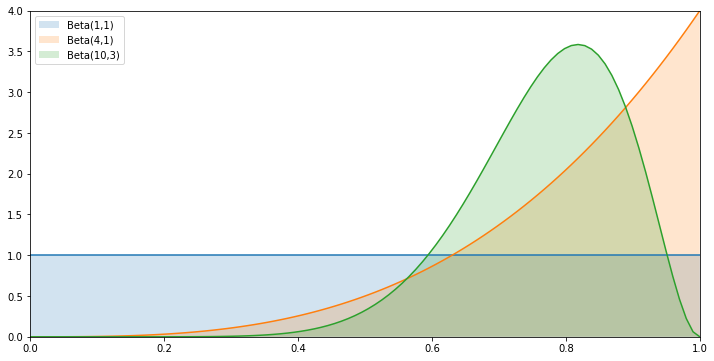

In [7]:
p = beta(1,1)
p2 = beta(4,1)
p3 = beta(10,3)
x = np.linspace(0, 1, 100)
plt.plot(x, p.pdf(x))
plt.fill_between( x, 0, p.pdf(x), alpha = 0.2, label='Beta(1,1)')
plt.plot(x, p2.pdf(x))
plt.fill_between( x, 0, p2.pdf(x), alpha = 0.2, label='Beta(4,1)')
plt.plot(x, p3.pdf(x))
plt.fill_between( x, 0, p3.pdf(x), alpha = 0.2, label='Beta(10,3)')
plt.legend()
plt.autoscale(tight=True)

# Uninformative priors

The **location prior** above can produce any sample on the real line. Thus, this ﬂat prior is not a probability density because it does not integrate to a finite number. Such a prior is called an **improper prior**. It expresses our state of ignorance on the random variable in question.
Despite the fact that this prior is both improper and dependent on parametrization, it is widely used.

If an improper prior does not lead to an improper posterior (a posterior that does not integrate to a finite number), we are fine. For example, one can start with a flat prior and a gaussian likelihood. The gaussian posterior then has a well defined integral.

## Jeffreys prior

We can use jeffreys prior to construct **priors scale variables**, such as precision/variance of a gaussian.

The point of Jeffreys priors is to create priors that don't become informative when you transform the variables. Jeffrey priors are defined as: $$p_J(\theta) \propto I(\theta)^{1/2}$$

This is used in linear regression.

Read Chapter 8. Degroot for more information.

# KL-maximization priors
Jose Bernardo (The bayesian choice) choses priors by maximising the KL-divergence between prior and posterior. This means maximizing the information brought by the data. 

# Weakly informative or regularizing prior

A related idea is the weakly informative prior, which attempts to ‘regularize’ the posterior by keeping it within reasonable bounds, but which tries not to affect the data as much as possible. Thus for example, 

- one might restrict a uniform prior to a specific range
- broaden a highly informative gaussian prior to diffuse the information. 
- One might use a $\gamma$ for a positive quantity such as a precision or variance, 
- or a half-cauchy if we wish to not limit the possibility of outliers on the positive axis.
- A gaussian prior can be used for priora on the entire real line but we often get away with using a gaussian prior which dies quickly on the positive axis. 
- If we need to deal with outliers on the whole real line we might use a fully cauchy or a students t.
We will see all of these priors as we deal with individual examples right through this course.

In [8]:
# this code is taken from https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section4_2-MCMC.ipynb

rnorm = np.random.normal
runif = np.random.rand

def metropolis(posterior, n_iterations, initial_values, prop_std=[1,1], doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = posterior(*trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print('Iterations left: ', n_iterations-i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob/current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted


In [9]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

In [14]:
from scipy.stats import norm
data=[-1, 1]
lik = lambda mu, sigma: np.prod(norm.pdf(data, mu, sigma))
prior_mu = lambda mu: 1
prior_sigma = lambda sigma: 1*(sigma > 0)
post = lambda mu, sigma: lik(mu, sigma)*prior_mu(mu)*prior_sigma(sigma)

In [20]:
mu0=0
sigma0=1
nsamps=50000
samps, acc = metropolis(post, nsamps, [mu0, sigma0], [50,50])

Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000


In [21]:
np.array(acc)/nsamps


array([0.61544, 0.59056])

In [22]:
acc

[30772, 29528]

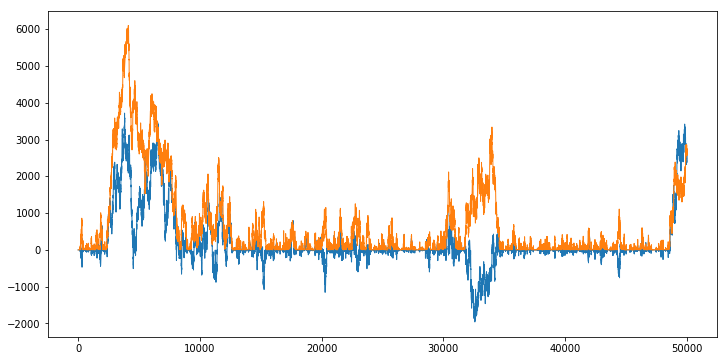

In [25]:
plt.plot(samps, lw=1);

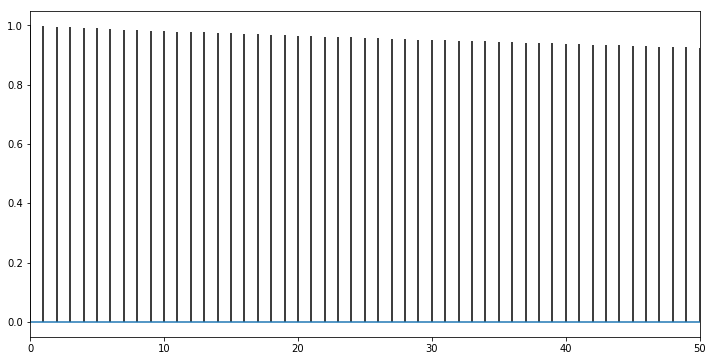

In [26]:
corrplot(samps[10000:,0])


The reason the model above drifts wildly in both dimensions is that there is very little data, just two observations, and flat priors. The flat priors say that every possible value of the parameter is equally plausible, a priori. For parameters that can take a potentially infinite number of values, like alpha, this means the Markov chain needs to occasionally sample some pretty extreme and implausible values, like negative 30 million. These extreme drifts overwhelm the chain. If the likelihood were stronger, then the chain would be fine, because it would stick closer to zero. (McElreath 258-259)

We now put 2 weakly regularizig priors in. A normal on the mean with a wide width of 10, and a half-cauchy on the standard-deviation with a scale of 1, which gets pretty low by 6, but remember its a cauchy, so you can still occasionally get really large samples…

In [27]:
from scipy.stats import halfcauchy
prior_mu_2 = lambda mu: norm.pdf(mu, 0, 10)
prior_sigma_2 = lambda sigma: halfcauchy.pdf(sigma)

I tried to plot a likelihood for a fixed $\sigma=3$ on the same scale as the priors, so that we can get an idea of what these look like..

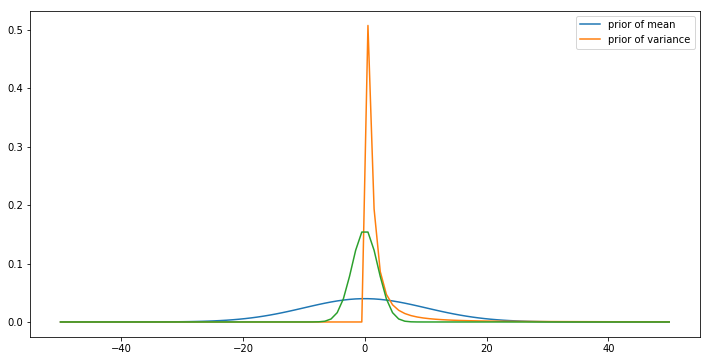

In [30]:
xx=np.linspace(-50,50,100)
plt.plot(xx, prior_mu_2(xx), label='prior of mean');
plt.plot(xx, prior_sigma_2(xx), label='prior of variance');
likmu = lambda mulist: [10*lik(mu, 3) for mu in mulist]
plt.plot(xx, likmu(xx));
plt.legend()

In [31]:
post2 = lambda mu, sigma: lik(mu, sigma)*prior_mu_2(mu)*prior_sigma_2(sigma)


In [32]:
mu0=0
sigma0=1
nsamps=50000
samps2, acc2 = metropolis(post2, nsamps, [mu0, sigma0], [4,2])

Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000


In [33]:
np.array(acc2)/nsamps


array([0.34562, 0.37716])

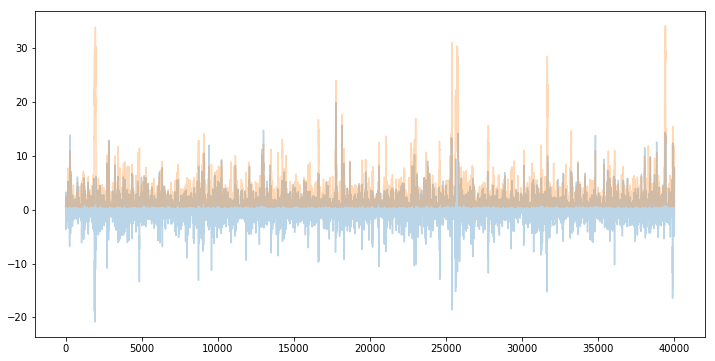

In [34]:
plt.plot(samps2[10000:], alpha=0.3)


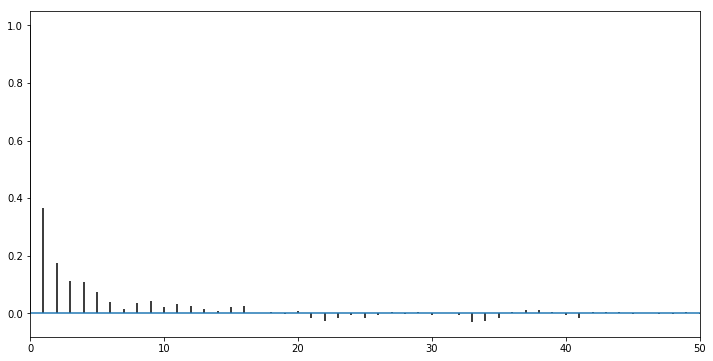

In [35]:
corrplot(samps2[10000::5,0])


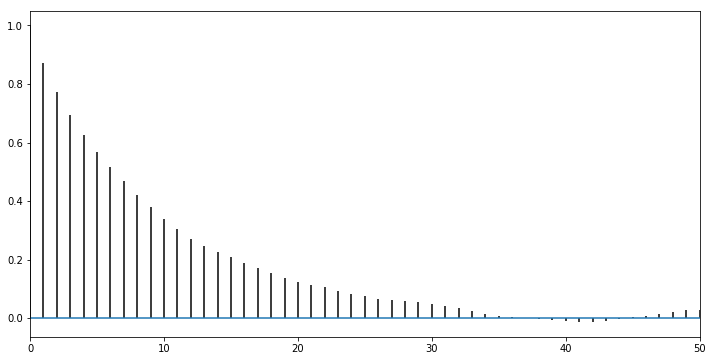

In [36]:
corrplot(samps2[10000::5,1])


(-10, 15)

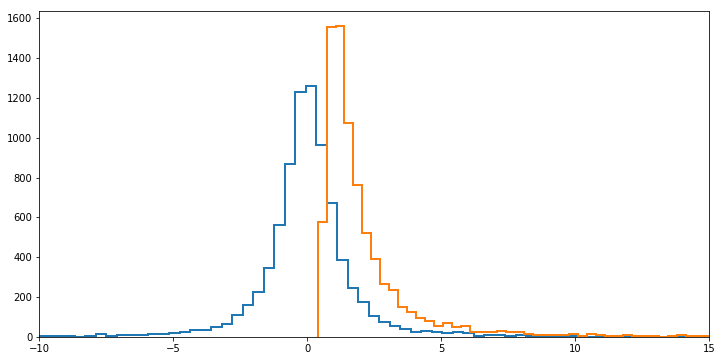

In [37]:
plt.hist(samps2[10000::5,0], histtype="step", lw=2, bins=100, label='variance')
plt.hist(samps2[10000::5,1], histtype="step", lw=2, bins=100);

plt.xlim([-10,15])